In [5]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, tensorflow as tf
import sys, time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, MaxPooling1D, GlobalAveragePooling1D, Conv1DTranspose, LSTM, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [6]:
from tensorflow.keras import backend as K

def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

In [7]:
MODEL = 0 # 0 = th v air, 1 = el v sky

In [9]:
index = [0,3] if MODEL==0 else [1,2]
model_name = 'th_v_air' if MODEL==0 else 'el_v_sky'

base_data_train, base_data_test = np.load('../../data/training_data/training_data_1month.npy', allow_pickle=True)

vae_data_train = np.load(f'../../data/test_vae_data/{model_name}_generated_samples.npy')
vae_data_train_rescaled = np.load(f'../../data/test_vae_data/{model_name}_rescaled_samples.npy')

gan_data_train = np.load(f'../../data/gan_synthetic_data/{model_name}_generated_samples.npy')
gan_data_train_rescaled = np.load(f'../../data/gan_synthetic_data/{model_name}_rescaled_samples.npy')

base_data_train, base_data_test, vae_data_train = base_data_train[:,:,index], base_data_test[:,:,index], vae_data_train[:,:,[0,1]]
print(base_data_train.shape,vae_data_train.shape,gan_data_train.shape)

(108, 730, 2) (1000, 730, 2) (1000, 730, 2)


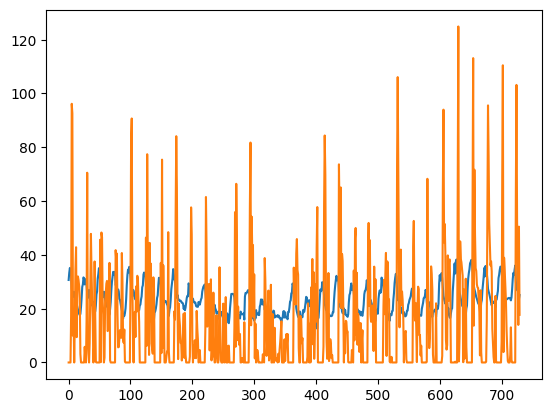

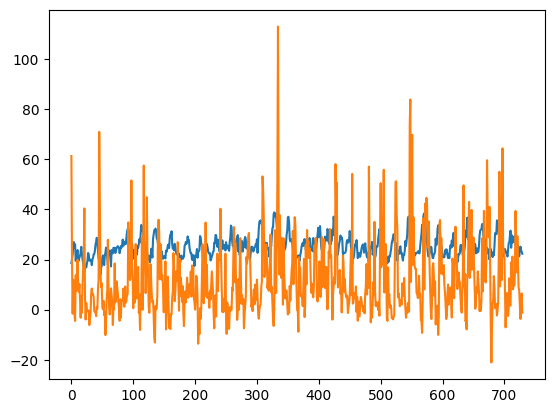

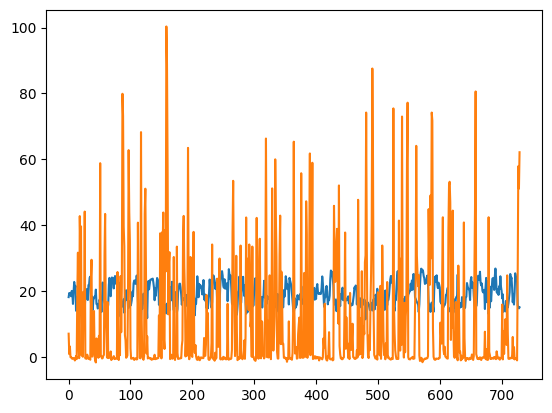

In [10]:
plt.plot(base_data_train[100])
plt.show()
plt.plot(vae_data_train_rescaled[100])
plt.show()
plt.plot(gan_data_train_rescaled[100])
plt.show()

In [11]:
'''def create_cnn(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(input_shape)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(730, activation='linear') #Dense(1)
    ])
    return model

def create_cnn(input_length):
    model = Sequential([
        Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(input_length, 1)),
        Dropout(0.5),
        LSTM(32, return_sequences=True),
        GlobalAveragePooling1D(),
        Dense(50, activation='relu'),
        Dense(730, activation='linear')  # Output layer for regression
    ])
    return model'''

"def create_cnn(input_shape):\n    model = Sequential([\n        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(input_shape)),\n        MaxPooling1D(pool_size=2),\n        Flatten(),\n        Dense(50, activation='relu'),\n        Dense(730, activation='linear') #Dense(1)\n    ])\n    return model\n\ndef create_cnn(input_length):\n    model = Sequential([\n        Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(input_length, 1)),\n        Dropout(0.5),\n        LSTM(32, return_sequences=True),\n        GlobalAveragePooling1D(),\n        Dense(50, activation='relu'),\n        Dense(730, activation='linear')  # Output layer for regression\n    ])\n    return model"

In [12]:
def create_cnn(input_shape):
    model = Sequential([
        Conv1D(filters=32, kernel_size=24, activation='relu', input_shape=(input_shape)),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        Conv1D(filters=64, kernel_size=24, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(730, activation='linear')
    ])
    return model

In [13]:
print(base_data_train[:,:,0].shape)

(108, 730)


In [14]:
def test_cnn(training_data):
    X_train = training_data[:,:,0].reshape(-1,730,1)
    y_train = training_data[:,:,1]

    X_test = scaled_data_test[:,:,0].reshape(-1, 730, 1)  
    y_test = scaled_data_test[:,:,1]

    X_train, X_train_val, y_train, y_train_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)
                                                                  
    model = create_cnn((X_train.shape[1], X_train.shape[2]))
    model.compile(optimizer=Adam(), loss='mse', metrics=['mse', 'mae'])

    early_stopping = EarlyStopping(monitor='mse', patience=10, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='mse', factor=0.5, patience=5, verbose=1)
    model.fit(X_train, y_train, epochs=100, batch_size=16, callbacks=[early_stopping, reduce_lr], verbose=0, validation_data=(X_train_val, y_train_val))

    loss, mse, mae = model.evaluate(X_test, y_test)
    r2 = r_squared(tf.convert_to_tensor(y_test, dtype=tf.float32), tf.convert_to_tensor(model.predict(X_test), dtype=tf.float32))
    
    return {'mse':mse, 'mae':mae, 'r2':r2.numpy()}


<h3> Scaling data before evaluation </h3>

Scale base dataset and use the scaled vae dataset

In [15]:
from sklearn.preprocessing import MinMaxScaler

scalers = {var_name: MinMaxScaler(feature_range=(-1,1)) for var_name in ['G.air.T', 'G.E_th_I']}

temp_var, energy_var = base_data_train[:,:,0], base_data_train[:,:,1]
temp_var_test, energy_var_test = base_data_test[:,:,0], base_data_test[:,:,1]

temp_var, temp_var_test = scalers['G.air.T'].fit_transform(temp_var), scalers['G.air.T'].fit_transform(temp_var_test)
energy_var, energy_var_test = scalers['G.E_th_I'].fit_transform(energy_var), scalers['G.E_th_I'].fit_transform(energy_var_test)

scaled_data_train, scaled_data_test = np.stack((temp_var, energy_var), axis=-1), np.stack((temp_var_test, energy_var_test), axis=-1)
print(scaled_data_train.shape, scaled_data_test.shape)

(108, 730, 2) (12, 730, 2)


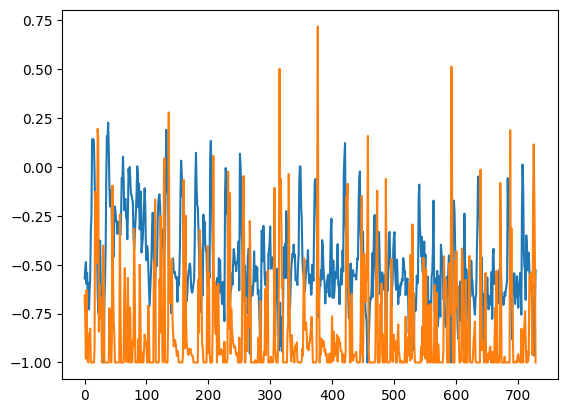

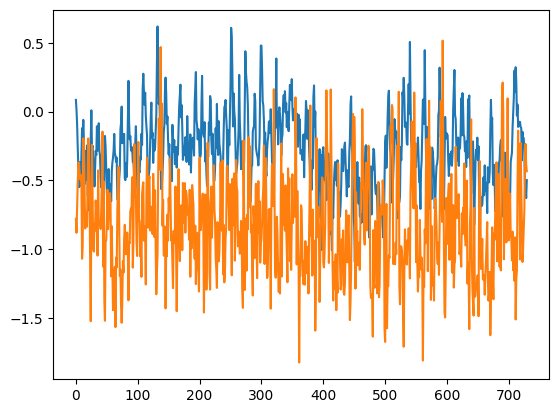

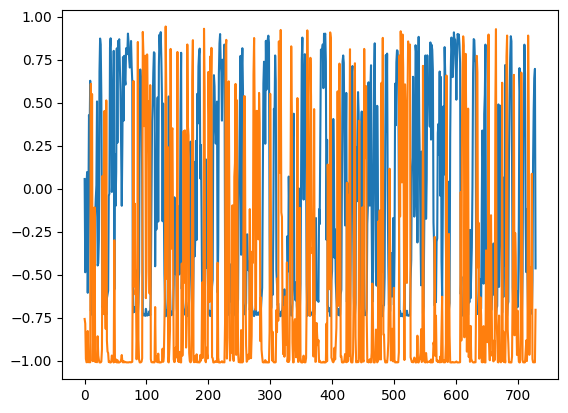

In [16]:
plt.plot(scaled_data_train[10])
plt.show()
plt.plot(vae_data_train[10])
plt.show()
plt.plot(gan_data_train[10])
plt.show()

In [17]:
import tensorflow as tf

# Hide GPU from visible devices
#tf.config.set_visible_devices([], 'GPU')
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [18]:
def test_cnn_wrapper(data):
    mse, mae, r2 = 0, 0, 0

    # Run each CNN training 10 times to ensure results are significant and not outliers
    for i in range(50):
        print(f'RUN: {i}')
        results = test_cnn(np.random.permutation(data)) # permuting the data for each run just to ensure full shuffling
        mse += results['mse']
        mae += results['mae']
        r2  += results['r2']

    return {'mse':mse/50, 'mae':mae/50, 'r2':r2/50}
        

<h3> Use CNN to assess ground truth data </h3>

In [19]:
gt_test = test_cnn_wrapper(scaled_data_train)
print(gt_test['mse'], gt_test['mae'], gt_test['r2'])

RUN: 0




1/1 [==============================] - 0s 121ms/step
RUN: 1

Epoch 82: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1/1 [==============================] - 0s 94ms/step
RUN: 2
1/1 [==============================] - 0s 249ms/step
RUN: 3
1/1 [==============================] - 0s 78ms/step
RUN: 4
1/1 [==============================] - 0s 73ms/step
RUN: 5
1/1 [==============================] - 0s 76ms/step
RUN: 6
1/1 [==============================] - 0s 78ms/step
RUN: 7
1/1 [==============================] - 0s 78ms/step
RUN: 8

Epoch 52: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 67: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1/1 [==============================] - 0s 78ms/step
RUN: 9
1/1 [==============================] - 0s 78ms/step
RUN: 10
1/1 [==============================] - 0s 78ms/step
RUN: 11
1/1 [==============================] - 0s 94ms/step
RUN: 12
1/1 [==============================] - 0s 

<h3> Use CNN to assess synthetic data</h3>

VAEs

In [29]:
synth_test = test_cnn_wrapper(vae_data_train)
print(synth_test['mse'], synth_test['mae'], synth_test['r2'])

RUN: 0
1/1 [==============================] - 0s 84ms/step
RUN: 1
1/1 [==============================] - 0s 79ms/step
RUN: 2
1/1 [==============================] - 0s 116ms/step
RUN: 3

Epoch 92: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1/1 [==============================] - 0s 86ms/step
RUN: 4
1/1 [==============================] - 0s 68ms/step
RUN: 5
1/1 [==============================] - 0s 82ms/step
RUN: 6
1/1 [==============================] - 0s 71ms/step
RUN: 7
1/1 [==============================] - 0s 82ms/step
RUN: 8
1/1 [==============================] - 0s 86ms/step
RUN: 9
1/1 [==============================] - 0s 78ms/step
0.7203199863433838 0.689084130525589 -0.0546762228012085


GANs

In [32]:
synth_test_gan = test_cnn_wrapper(gan_data_train[0:532,:,:])
print(synth_test_gan['mse'], synth_test_gan['mae'], synth_test_gan['r2'])

RUN: 0

Epoch 72: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 95: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1/1 [==============================] - 0s 83ms/step
RUN: 1

Epoch 47: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 95: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1/1 [==============================] - 0s 82ms/step
RUN: 2

Epoch 69: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1/1 [==============================] - 0s 86ms/step
RUN: 3

Epoch 59: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 83: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 97: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
1/1 [==============================] - 0s 72ms/step
RUN: 4

Epoch 86: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 97: ReduceLROnPlateau reducing learning rate to 

<h3> Use CNN to evaluate synthetic-ground truth blended data</h3>

VAEs

In [28]:
blended_data = np.concatenate((scaled_data_train, vae_data_train), axis=0)
blended_test = test_cnn_wrapper(blended_data)
print(blended_test['mse'], blended_test['mae'], blended_test['r2'])

RUN: 0

Epoch 72: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 80: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 87: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 95: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
1/1 [==============================] - 0s 121ms/step
RUN: 1

Epoch 94: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1/1 [==============================] - 0s 91ms/step
RUN: 2

Epoch 83: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1/1 [==============================] - 0s 82ms/step
RUN: 3

Epoch 69: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 83: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 96: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
1/1 [==============================] - 0s 117ms/step
RUN: 4

Epoch 86: ReduceLROnPlateau reducing learning rate to

26/32 [=======================>......] - ETA: 0s - loss: 0.0588 - mse: 0.0588 - mae: 0.1836 - accuracy: 0.2837
Epoch 45: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
32/32 [==============================] - 0s 9ms/step - loss: 0.0614 - mse: 0.0614 - mae: 0.1854 - accuracy: 0.2871 - val_loss: 0.0712 - val_mse: 0.0712 - val_mae: 0.2014 - val_accuracy: 0.2969 - lr: 0.0010
Epoch 46/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0534 - mse: 0.0534 - mae: 0.1708 - accuracy: 0.2754 - val_loss: 0.0656 - val_mse: 0.0656 - val_mae: 0.1914 - val_accuracy: 0.2812 - lr: 5.0000e-04
Epoch 47/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0524 - mse: 0.0524 - mae: 0.1693 - accuracy: 0.2910 - val_loss: 0.0624 - val_mse: 0.0624 - val_mae: 0.1843 - val_accuracy: 0.2969 - lr: 5.0000e-04
Epoch 48/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0519 - mse: 0.0519 - mae: 0.1680 - accuracy: 0.2676 - val_loss: 0.0604 - val_mse: 0.

32/32 [==============================] - 0s 6ms/step - loss: 0.1005 - mse: 0.1005 - mae: 0.2345 - accuracy: 0.1602 - val_loss: 0.1015 - val_mse: 0.1015 - val_mae: 0.2428 - val_accuracy: 0.1719 - lr: 0.0010
Epoch 16/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0953 - mse: 0.0953 - mae: 0.2279 - accuracy: 0.1777 - val_loss: 0.0799 - val_mse: 0.0799 - val_mae: 0.2163 - val_accuracy: 0.1719 - lr: 0.0010
Epoch 17/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0971 - mse: 0.0971 - mae: 0.2285 - accuracy: 0.1855 - val_loss: 0.0826 - val_mse: 0.0826 - val_mae: 0.2194 - val_accuracy: 0.1875 - lr: 0.0010
Epoch 18/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0914 - mse: 0.0914 - mae: 0.2227 - accuracy: 0.1992 - val_loss: 0.0805 - val_mse: 0.0805 - val_mae: 0.2162 - val_accuracy: 0.1719 - lr: 0.0010
Epoch 19/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0866 - mse: 0.0866 - mae: 0.2161 - accuracy: 0.1895 - val_los

Epoch 87/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0407 - mse: 0.0407 - mae: 0.1485 - accuracy: 0.3242 - val_loss: 0.0499 - val_mse: 0.0499 - val_mae: 0.1654 - val_accuracy: 0.3828 - lr: 2.5000e-04
Epoch 88/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0408 - mse: 0.0408 - mae: 0.1484 - accuracy: 0.3262 - val_loss: 0.0477 - val_mse: 0.0477 - val_mae: 0.1605 - val_accuracy: 0.3516 - lr: 2.5000e-04
Epoch 89/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0407 - mse: 0.0407 - mae: 0.1486 - accuracy: 0.3281 - val_loss: 0.0472 - val_mse: 0.0472 - val_mae: 0.1596 - val_accuracy: 0.3359 - lr: 2.5000e-04
Epoch 90/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0413 - mse: 0.0413 - mae: 0.1497 - accuracy: 0.3145 - val_loss: 0.0491 - val_mse: 0.0491 - val_mae: 0.1639 - val_accuracy: 0.3594 - lr: 2.5000e-04
Epoch 91/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0399 - mse: 0.0399 - mae: 0.1467

32/32 [==============================] - 0s 9ms/step - loss: 0.0511 - mse: 0.0511 - mae: 0.1677 - accuracy: 0.3086 - val_loss: 0.0676 - val_mse: 0.0676 - val_mae: 0.1923 - val_accuracy: 0.2578 - lr: 5.0000e-04
Epoch 59/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0493 - mse: 0.0493 - mae: 0.1631 - accuracy: 0.3047 - val_loss: 0.0634 - val_mse: 0.0634 - val_mae: 0.1846 - val_accuracy: 0.2500 - lr: 5.0000e-04
Epoch 60/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0478 - mse: 0.0478 - mae: 0.1608 - accuracy: 0.3203 - val_loss: 0.0596 - val_mse: 0.0596 - val_mae: 0.1768 - val_accuracy: 0.2422 - lr: 5.0000e-04
Epoch 61/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0485 - mse: 0.0485 - mae: 0.1618 - accuracy: 0.2949 - val_loss: 0.0660 - val_mse: 0.0660 - val_mae: 0.1916 - val_accuracy: 0.2578 - lr: 5.0000e-04
Epoch 62/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0482 - mse: 0.0482 - mae: 0.1618 - accuracy: 

Epoch 29/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0753 - mse: 0.0753 - mae: 0.2052 - accuracy: 0.2129 - val_loss: 0.0807 - val_mse: 0.0807 - val_mae: 0.2115 - val_accuracy: 0.2188 - lr: 0.0010
Epoch 30/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0674 - mse: 0.0674 - mae: 0.1942 - accuracy: 0.2051 - val_loss: 0.0778 - val_mse: 0.0778 - val_mae: 0.2037 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 31/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0698 - mse: 0.0698 - mae: 0.1984 - accuracy: 0.1914 - val_loss: 0.0847 - val_mse: 0.0847 - val_mae: 0.2125 - val_accuracy: 0.2812 - lr: 0.0010
Epoch 32/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0703 - mse: 0.0703 - mae: 0.1991 - accuracy: 0.2148 - val_loss: 0.0869 - val_mse: 0.0869 - val_mae: 0.2205 - val_accuracy: 0.2422 - lr: 0.0010
Epoch 33/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0703 - mse: 0.0703 - mae: 0.1969 - accuracy: 0.2

32/32 [==============================] - 0s 9ms/step - loss: 0.0427 - mse: 0.0427 - mae: 0.1516 - accuracy: 0.2930 - val_loss: 0.0580 - val_mse: 0.0580 - val_mae: 0.1712 - val_accuracy: 0.3203 - lr: 6.2500e-05
Epoch 100/100
1/1 [==============================] - 0s 61ms/step
RUN: 5
Epoch 1/100
32/32 [==============================] - 1s 14ms/step - loss: 0.5622 - mse: 0.5622 - mae: 0.6114 - accuracy: 0.0020 - val_loss: 0.4352 - val_mse: 0.4352 - val_mae: 0.5504 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.3758 - mse: 0.3758 - mae: 0.4674 - accuracy: 0.0156 - val_loss: 0.2861 - val_mse: 0.2861 - val_mae: 0.4194 - val_accuracy: 0.0469 - lr: 0.0010
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2558 - mse: 0.2558 - mae: 0.3817 - accuracy: 0.0352 - val_loss: 0.2125 - val_mse: 0.2125 - val_mae: 0.3581 - val_accuracy: 0.0391 - lr: 0.0010
Epoch 4/100
32/32 [==============================] - 0s 8m

Epoch 36/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0718 - mse: 0.0718 - mae: 0.1963 - accuracy: 0.2344 - val_loss: 0.0695 - val_mse: 0.0695 - val_mae: 0.1989 - val_accuracy: 0.2031 - lr: 0.0010
Epoch 37/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0671 - mse: 0.0671 - mae: 0.1923 - accuracy: 0.2227 - val_loss: 0.0747 - val_mse: 0.0747 - val_mae: 0.2094 - val_accuracy: 0.2266 - lr: 0.0010
Epoch 38/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0635 - mse: 0.0635 - mae: 0.1869 - accuracy: 0.2246 - val_loss: 0.0760 - val_mse: 0.0760 - val_mae: 0.2115 - val_accuracy: 0.2344 - lr: 0.0010
Epoch 39/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0787 - mse: 0.0787 - mae: 0.2033 - accuracy: 0.2500 - val_loss: 0.0720 - val_mse: 0.0720 - val_mae: 0.2031 - val_accuracy: 0.2109 - lr: 0.0010
Epoch 40/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0838 - mse: 0.0838 - mae: 0.2120 - accuracy: 0.2

Epoch 72/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0475 - mse: 0.0475 - mae: 0.1616 - accuracy: 0.3125 - val_loss: 0.0573 - val_mse: 0.0573 - val_mae: 0.1784 - val_accuracy: 0.2969 - lr: 2.5000e-04
Epoch 73/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0465 - mse: 0.0465 - mae: 0.1590 - accuracy: 0.2930 - val_loss: 0.0593 - val_mse: 0.0593 - val_mae: 0.1834 - val_accuracy: 0.2969 - lr: 2.5000e-04
Epoch 74/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0465 - mse: 0.0465 - mae: 0.1589 - accuracy: 0.3027 - val_loss: 0.0598 - val_mse: 0.0598 - val_mae: 0.1838 - val_accuracy: 0.2969 - lr: 2.5000e-04
Epoch 75/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0462 - mse: 0.0462 - mae: 0.1583 - accuracy: 0.3008 - val_loss: 0.0580 - val_mse: 0.0580 - val_mae: 0.1802 - val_accuracy: 0.2969 - lr: 2.5000e-04
Epoch 76/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0446 - mse: 0.0446 - mae: 0.1555

32/32 [==============================] - 0s 9ms/step - loss: 0.0589 - mse: 0.0589 - mae: 0.1810 - accuracy: 0.2461 - val_loss: 0.0596 - val_mse: 0.0596 - val_mae: 0.1835 - val_accuracy: 0.2656 - lr: 0.0010
Epoch 44/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0562 - mse: 0.0562 - mae: 0.1779 - accuracy: 0.2812 - val_loss: 0.0657 - val_mse: 0.0657 - val_mae: 0.1966 - val_accuracy: 0.3203 - lr: 0.0010
Epoch 45/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0554 - mse: 0.0554 - mae: 0.1748 - accuracy: 0.2559 - val_loss: 0.0629 - val_mse: 0.0629 - val_mae: 0.1932 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 46/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0570 - mse: 0.0570 - mae: 0.1780 - accuracy: 0.2949 - val_loss: 0.0641 - val_mse: 0.0641 - val_mae: 0.1922 - val_accuracy: 0.3047 - lr: 0.0010
Epoch 47/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0582 - mse: 0.0582 - mae: 0.1806 - accuracy: 0.2852 - val_los

32/32 [==============================] - 0s 9ms/step - loss: 0.1032 - mse: 0.1032 - mae: 0.2369 - accuracy: 0.1211 - val_loss: 0.0951 - val_mse: 0.0951 - val_mae: 0.2304 - val_accuracy: 0.1016 - lr: 0.0010
Epoch 14/100
32/32 [==============================] - 0s 9ms/step - loss: 0.1079 - mse: 0.1079 - mae: 0.2438 - accuracy: 0.1250 - val_loss: 0.1003 - val_mse: 0.1003 - val_mae: 0.2429 - val_accuracy: 0.1016 - lr: 0.0010
Epoch 15/100
32/32 [==============================] - 0s 9ms/step - loss: 0.1071 - mse: 0.1071 - mae: 0.2438 - accuracy: 0.1270 - val_loss: 0.0966 - val_mse: 0.0966 - val_mae: 0.2384 - val_accuracy: 0.1016 - lr: 0.0010
Epoch 16/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0941 - mse: 0.0941 - mae: 0.2277 - accuracy: 0.1504 - val_loss: 0.0981 - val_mse: 0.0981 - val_mae: 0.2342 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 17/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0922 - mse: 0.0922 - mae: 0.2244 - accuracy: 0.1406 - val_los

Epoch 86/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0399 - mse: 0.0399 - mae: 0.1470 - accuracy: 0.3145 - val_loss: 0.0512 - val_mse: 0.0512 - val_mae: 0.1668 - val_accuracy: 0.3047 - lr: 5.0000e-04
Epoch 87/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0398 - mse: 0.0398 - mae: 0.1462 - accuracy: 0.3633 - val_loss: 0.0564 - val_mse: 0.0564 - val_mae: 0.1744 - val_accuracy: 0.3047 - lr: 5.0000e-04
Epoch 88/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0410 - mse: 0.0410 - mae: 0.1494 - accuracy: 0.3633 - val_loss: 0.0587 - val_mse: 0.0587 - val_mae: 0.1739 - val_accuracy: 0.3438 - lr: 5.0000e-04
Epoch 89/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0418 - mse: 0.0418 - mae: 0.1510 - accuracy: 0.3340 - val_loss: 0.0509 - val_mse: 0.0509 - val_mae: 0.1668 - val_accuracy: 0.2812 - lr: 5.0000e-04
Epoch 90/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0402 - mse: 0.0402 - mae: 0.1477

32/32 [==============================] - 0s 9ms/step - loss: 0.0537 - mse: 0.0537 - mae: 0.1713 - accuracy: 0.2773 - val_loss: 0.0717 - val_mse: 0.0717 - val_mae: 0.1912 - val_accuracy: 0.2500 - lr: 5.0000e-04
Epoch 58/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0517 - mse: 0.0517 - mae: 0.1686 - accuracy: 0.3008 - val_loss: 0.0762 - val_mse: 0.0762 - val_mae: 0.1955 - val_accuracy: 0.2578 - lr: 5.0000e-04
Epoch 59/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0572 - mse: 0.0572 - mae: 0.1749 - accuracy: 0.2832 - val_loss: 0.0726 - val_mse: 0.0726 - val_mae: 0.1918 - val_accuracy: 0.2500 - lr: 5.0000e-04
Epoch 60/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0545 - mse: 0.0545 - mae: 0.1711 - accuracy: 0.2754 - val_loss: 0.0723 - val_mse: 0.0723 - val_mae: 0.1938 - val_accuracy: 0.2422 - lr: 5.0000e-04
Epoch 61/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0533 - mse: 0.0533 - mae: 0.1706 - accuracy: 

Epoch 28/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0710 - mse: 0.0710 - mae: 0.1974 - accuracy: 0.2266 - val_loss: 0.0909 - val_mse: 0.0909 - val_mae: 0.2196 - val_accuracy: 0.1797 - lr: 0.0010
Epoch 29/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0699 - mse: 0.0699 - mae: 0.1974 - accuracy: 0.2285 - val_loss: 0.0949 - val_mse: 0.0949 - val_mae: 0.2257 - val_accuracy: 0.1953 - lr: 0.0010
Epoch 30/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0811 - mse: 0.0811 - mae: 0.2136 - accuracy: 0.2285 - val_loss: 0.0990 - val_mse: 0.0990 - val_mae: 0.2305 - val_accuracy: 0.1797 - lr: 0.0010
Epoch 31/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0744 - mse: 0.0744 - mae: 0.2032 - accuracy: 0.2285 - val_loss: 0.1034 - val_mse: 0.1034 - val_mae: 0.2379 - val_accuracy: 0.1875 - lr: 0.0010
Epoch 32/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0723 - mse: 0.0723 - mae: 0.1986 - accuracy: 0.2

Epoch 100/100
1/1 [==============================] - 0s 60ms/step
0.3662218123674393 0.45536904633045194 0.11112428307533265


In [33]:
blended_data_gan = np.concatenate((scaled_data_train, gan_data_train[0:532,:,:]), axis=0)
blended_test_gan = test_cnn_wrapper(blended_data_gan)
print(blended_test_gan['mse'], blended_test_gan['mae'], blended_test_gan['r2'])

RUN: 0

Epoch 67: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 87: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1/1 [==============================] - 0s 88ms/step
RUN: 1

Epoch 67: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 99: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1/1 [==============================] - 0s 85ms/step
RUN: 2

Epoch 65: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 79: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 97: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
1/1 [==============================] - 0s 85ms/step
RUN: 3

Epoch 76: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1/1 [==============================] - 0s 85ms/step
RUN: 4

Epoch 75: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1/1 [==============================] - 0s 86ms/step
RUN

32/32 [==============================] - 0s 9ms/step - loss: 0.3043 - mse: 0.3043 - mae: 0.4183 - accuracy: 0.0000e+00 - val_loss: 0.3264 - val_mse: 0.3264 - val_mae: 0.4647 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 12/100
32/32 [==============================] - 0s 9ms/step - loss: 0.3013 - mse: 0.3013 - mae: 0.4140 - accuracy: 0.0078 - val_loss: 0.3264 - val_mse: 0.3264 - val_mae: 0.4648 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 13/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2985 - mse: 0.2985 - mae: 0.4114 - accuracy: 0.0039 - val_loss: 0.3227 - val_mse: 0.3227 - val_mae: 0.4438 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 14/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2962 - mse: 0.2962 - mae: 0.4086 - accuracy: 0.0059 - val_loss: 0.3335 - val_mse: 0.3335 - val_mae: 0.4856 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 15/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2947 - mse: 0.2947 - mae: 0.4082 - accuracy: 0.00

Epoch 48/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2471 - mse: 0.2471 - mae: 0.3699 - accuracy: 0.0293 - val_loss: 0.3152 - val_mse: 0.3152 - val_mae: 0.4444 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 49/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2469 - mse: 0.2469 - mae: 0.3702 - accuracy: 0.0254 - val_loss: 0.3128 - val_mse: 0.3128 - val_mae: 0.4263 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 50/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2469 - mse: 0.2469 - mae: 0.3706 - accuracy: 0.0273 - val_loss: 0.3133 - val_mse: 0.3133 - val_mae: 0.4248 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 51/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2466 - mse: 0.2466 - mae: 0.3698 - accuracy: 0.0176 - val_loss: 0.3138 - val_mse: 0.3138 - val_mae: 0.4404 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 52/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2465 - mse: 0.2465 - mae: 0.3703

Epoch 84/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2387 - mse: 0.2387 - mae: 0.3641 - accuracy: 0.0254 - val_loss: 0.3092 - val_mse: 0.3092 - val_mae: 0.4272 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 85/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2388 - mse: 0.2388 - mae: 0.3639 - accuracy: 0.0332 - val_loss: 0.3092 - val_mse: 0.3092 - val_mae: 0.4321 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 86/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2387 - mse: 0.2387 - mae: 0.3636 - accuracy: 0.0293 - val_loss: 0.3087 - val_mse: 0.3087 - val_mae: 0.4246 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 87/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2386 - mse: 0.2386 - mae: 0.3638 - accuracy: 0.0215 - val_loss: 0.3089 - val_mse: 0.3089 - val_mae: 0.4282 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 88/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2386 - mse: 0.23

32/32 [==============================] - 0s 9ms/step - loss: 0.2956 - mse: 0.2956 - mae: 0.4081 - accuracy: 0.0078 - val_loss: 0.3130 - val_mse: 0.3130 - val_mae: 0.4509 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 20/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2926 - mse: 0.2926 - mae: 0.4059 - accuracy: 0.0137 - val_loss: 0.3153 - val_mse: 0.3153 - val_mae: 0.4580 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 21/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2902 - mse: 0.2902 - mae: 0.4048 - accuracy: 0.0098 - val_loss: 0.3116 - val_mse: 0.3116 - val_mae: 0.4470 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 22/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2884 - mse: 0.2884 - mae: 0.4025 - accuracy: 0.0195 - val_loss: 0.3110 - val_mse: 0.3110 - val_mae: 0.4420 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 23/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2867 - mse: 0.2867 - mae: 0.4009 - accuracy: 0.0156 - val_los

Epoch 93/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2509 - mse: 0.2509 - mae: 0.3733 - accuracy: 0.0332 - val_loss: 0.2994 - val_mse: 0.2994 - val_mae: 0.4276 - val_accuracy: 0.0078 - lr: 5.0000e-04
Epoch 94/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2503 - mse: 0.2503 - mae: 0.3728 - accuracy: 0.0371 - val_loss: 0.2983 - val_mse: 0.2983 - val_mae: 0.4240 - val_accuracy: 0.0078 - lr: 5.0000e-04
Epoch 95/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2500 - mse: 0.2500 - mae: 0.3724 - accuracy: 0.0273 - val_loss: 0.2980 - val_mse: 0.2980 - val_mae: 0.4210 - val_accuracy: 0.0078 - lr: 5.0000e-04
Epoch 96/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2498 - mse: 0.2498 - mae: 0.3720 - accuracy: 0.0371 - val_loss: 0.2976 - val_mse: 0.2976 - val_mae: 0.4203 - val_accuracy: 0.0078 - lr: 5.0000e-04
Epoch 97/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2499 - mse: 0.2499 - mae: 0.3724

Epoch 29/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2789 - mse: 0.2789 - mae: 0.3954 - accuracy: 0.0059 - val_loss: 0.3082 - val_mse: 0.3082 - val_mae: 0.4312 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 30/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2769 - mse: 0.2769 - mae: 0.3930 - accuracy: 0.0137 - val_loss: 0.3126 - val_mse: 0.3126 - val_mae: 0.4503 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 31/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2756 - mse: 0.2756 - mae: 0.3923 - accuracy: 0.0039 - val_loss: 0.3081 - val_mse: 0.3081 - val_mae: 0.4382 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 32/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2749 - mse: 0.2749 - mae: 0.3910 - accuracy: 0.0176 - val_loss: 0.3126 - val_mse: 0.3126 - val_mae: 0.4521 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 33/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2743 - mse: 0.2743 - mae: 0.3912 - a

Epoch 66/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2587 - mse: 0.2587 - mae: 0.3798 - accuracy: 0.0234 - val_loss: 0.3010 - val_mse: 0.3010 - val_mae: 0.4083 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 67/100
32/32 [==============================] - 0s 6ms/step - loss: 0.2589 - mse: 0.2589 - mae: 0.3795 - accuracy: 0.0176 - val_loss: 0.3014 - val_mse: 0.3014 - val_mae: 0.4211 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 68/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2586 - mse: 0.2586 - mae: 0.3792 - accuracy: 0.0234 - val_loss: 0.3059 - val_mse: 0.3059 - val_mae: 0.4421 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 69/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2582 - mse: 0.2582 - mae: 0.3791 - accuracy: 0.0254 - val_loss: 0.3012 - val_mse: 0.3012 - val_mae: 0.4252 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 70/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2585 - mse: 0.2585 - mae: 0.3800

Epoch 38/100
32/32 [==============================] - 0s 6ms/step - loss: 0.2759 - mse: 0.2759 - mae: 0.3925 - accuracy: 0.0195 - val_loss: 0.3098 - val_mse: 0.3098 - val_mae: 0.4410 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 39/100
32/32 [==============================] - 0s 6ms/step - loss: 0.2752 - mse: 0.2752 - mae: 0.3914 - accuracy: 0.0176 - val_loss: 0.3069 - val_mse: 0.3069 - val_mae: 0.4252 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 40/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2746 - mse: 0.2746 - mae: 0.3910 - accuracy: 0.0195 - val_loss: 0.3110 - val_mse: 0.3110 - val_mae: 0.4460 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 41/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2747 - mse: 0.2747 - mae: 0.3912 - accuracy: 0.0117 - val_loss: 0.3094 - val_mse: 0.3094 - val_mae: 0.4412 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 42/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2738 - mse: 0.2738 - mae: 0.3907 - a

Epoch 75/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2642 - mse: 0.2642 - mae: 0.3834 - accuracy: 0.0156 - val_loss: 0.3067 - val_mse: 0.3067 - val_mae: 0.4395 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 76/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2639 - mse: 0.2639 - mae: 0.3829 - accuracy: 0.0137 - val_loss: 0.3035 - val_mse: 0.3035 - val_mae: 0.4249 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 77/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2636 - mse: 0.2636 - mae: 0.3829 - accuracy: 0.0137 - val_loss: 0.3030 - val_mse: 0.3030 - val_mae: 0.4207 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 78/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2632 - mse: 0.2632 - mae: 0.3821 - accuracy: 0.0234 - val_loss: 0.3043 - val_mse: 0.3043 - val_mae: 0.4323 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 79/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2631 - mse: 0.2631 - mae: 0.3823

32/32 [==============================] - 0s 8ms/step - loss: 0.3060 - mse: 0.3060 - mae: 0.4191 - accuracy: 0.0137 - val_loss: 0.3088 - val_mse: 0.3088 - val_mae: 0.4279 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 12/100
32/32 [==============================] - 0s 8ms/step - loss: 0.3035 - mse: 0.3035 - mae: 0.4163 - accuracy: 0.0039 - val_loss: 0.3110 - val_mse: 0.3110 - val_mae: 0.4425 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 13/100
32/32 [==============================] - 0s 9ms/step - loss: 0.3000 - mse: 0.3000 - mae: 0.4132 - accuracy: 0.0078 - val_loss: 0.3103 - val_mse: 0.3103 - val_mae: 0.4436 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 14/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2972 - mse: 0.2972 - mae: 0.4104 - accuracy: 0.0137 - val_loss: 0.3201 - val_mse: 0.3201 - val_mae: 0.4742 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 15/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2951 - mse: 0.2951 - mae: 0.4090 - accuracy: 0.0117 - val_los

32/32 [==============================] - 0s 9ms/step - loss: 0.2488 - mse: 0.2488 - mae: 0.3730 - accuracy: 0.0176 - val_loss: 0.3000 - val_mse: 0.3000 - val_mae: 0.4276 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 49/100
32/32 [==============================] - 0s 6ms/step - loss: 0.2486 - mse: 0.2486 - mae: 0.3732 - accuracy: 0.0195 - val_loss: 0.3028 - val_mse: 0.3028 - val_mae: 0.4346 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 50/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2484 - mse: 0.2484 - mae: 0.3727 - accuracy: 0.0117 - val_loss: 0.3007 - val_mse: 0.3007 - val_mae: 0.4289 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 51/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2482 - mse: 0.2482 - mae: 0.3729 - accuracy: 0.0195 - val_loss: 0.3021 - val_mse: 0.3021 - val_mae: 0.4361 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 52/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2475 - mse: 0.2475 - mae: 0.3719 - accuracy: 

Epoch 85/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2419 - mse: 0.2419 - mae: 0.3682 - accuracy: 0.0254 - val_loss: 0.2981 - val_mse: 0.2981 - val_mae: 0.4269 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 86/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2416 - mse: 0.2416 - mae: 0.3678 - accuracy: 0.0293 - val_loss: 0.2960 - val_mse: 0.2960 - val_mae: 0.4173 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 87/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2413 - mse: 0.2413 - mae: 0.3674 - accuracy: 0.0234 - val_loss: 0.2974 - val_mse: 0.2974 - val_mae: 0.4235 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 88/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2416 - mse: 0.2416 - mae: 0.3679 - accuracy: 0.0332 - val_loss: 0.2963 - val_mse: 0.2963 - val_mae: 0.4158 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 89/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2412 - mse: 0.2412 - mae: 0.3677

32/32 [==============================] - 0s 9ms/step - loss: 0.2893 - mse: 0.2893 - mae: 0.4034 - accuracy: 0.0098 - val_loss: 0.3237 - val_mse: 0.3237 - val_mae: 0.4349 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 22/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2871 - mse: 0.2871 - mae: 0.4012 - accuracy: 0.0098 - val_loss: 0.3283 - val_mse: 0.3283 - val_mae: 0.4605 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 23/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2855 - mse: 0.2855 - mae: 0.4003 - accuracy: 0.0117 - val_loss: 0.3243 - val_mse: 0.3243 - val_mae: 0.4456 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 24/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2839 - mse: 0.2839 - mae: 0.3991 - accuracy: 0.0039 - val_loss: 0.3278 - val_mse: 0.3278 - val_mae: 0.4634 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 25/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2821 - mse: 0.2821 - mae: 0.3970 - accuracy: 0.01

Epoch 58/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2587 - mse: 0.2587 - mae: 0.3794 - accuracy: 0.0176 - val_loss: 0.3191 - val_mse: 0.3191 - val_mae: 0.4435 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 59/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2583 - mse: 0.2583 - mae: 0.3787 - accuracy: 0.0156 - val_loss: 0.3206 - val_mse: 0.3206 - val_mae: 0.4497 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 60/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2581 - mse: 0.2581 - mae: 0.3787 - accuracy: 0.0195 - val_loss: 0.3204 - val_mse: 0.3204 - val_mae: 0.4479 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 61/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2577 - mse: 0.2577 - mae: 0.3783 - accuracy: 0.0273 - val_loss: 0.3171 - val_mse: 0.3171 - val_mae: 0.4350 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 62/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2572 - mse: 0.2572 - mae: 0.3774

32/32 [==============================] - 0s 8ms/step - loss: 0.2522 - mse: 0.2522 - mae: 0.3737 - accuracy: 0.0195 - val_loss: 0.3153 - val_mse: 0.3153 - val_mae: 0.4335 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 95/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2522 - mse: 0.2522 - mae: 0.3734 - accuracy: 0.0156 - val_loss: 0.3146 - val_mse: 0.3146 - val_mae: 0.4273 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 96/100
32/32 [==============================] - 0s 6ms/step - loss: 0.2521 - mse: 0.2521 - mae: 0.3736 - accuracy: 0.0156 - val_loss: 0.3155 - val_mse: 0.3155 - val_mae: 0.4343 - val_accuracy: 0.0078 - lr: 5.0000e-04
Epoch 97/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2521 - mse: 0.2521 - mae: 0.3735 - accuracy: 0.0195 - val_loss: 0.3155 - val_mse: 0.3155 - val_mae: 0.4357 - val_accuracy: 0.0000e+00 - lr: 5.0000e-04
Epoch 98/100
32/32 [==============================] - 0s 5ms/step - loss: 0.2519 - mse: 0.2519 - mae: 0.3736 

32/32 [==============================] - 0s 9ms/step - loss: 0.2392 - mse: 0.2392 - mae: 0.3657 - accuracy: 0.0156 - val_loss: 0.3063 - val_mse: 0.3063 - val_mae: 0.4347 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 68/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2388 - mse: 0.2388 - mae: 0.3649 - accuracy: 0.0195 - val_loss: 0.3050 - val_mse: 0.3050 - val_mae: 0.4264 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 69/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2390 - mse: 0.2390 - mae: 0.3651 - accuracy: 0.0234 - val_loss: 0.3048 - val_mse: 0.3048 - val_mae: 0.4278 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 70/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2385 - mse: 0.2385 - mae: 0.3648 - accuracy: 0.0195 - val_loss: 0.3079 - val_mse: 0.3079 - val_mae: 0.4425 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 71/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2384 - mse: 0.2384 - mae: 0.3648 - accuracy: 0.0156 - val_los

Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.3311 - mse: 0.3311 - mae: 0.4419 - accuracy: 0.0000e+00 - val_loss: 0.3244 - val_mse: 0.3244 - val_mae: 0.4781 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.3262 - mse: 0.3262 - mae: 0.4404 - accuracy: 0.0020 - val_loss: 0.3217 - val_mse: 0.3217 - val_mae: 0.4732 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.3238 - mse: 0.3238 - mae: 0.4372 - accuracy: 0.0039 - val_loss: 0.3285 - val_mse: 0.3285 - val_mae: 0.4885 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/100
32/32 [==============================] - 0s 6ms/step - loss: 0.3230 - mse: 0.3230 - mae: 0.4375 - accuracy: 0.0039 - val_loss: 0.3105 - val_mse: 0.3105 - val_mae: 0.4200 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 7/100
32/32 [==============================] - 0s 6ms/step - loss: 0.3214 - mse: 0.3214 - mae: 0.4333 

Epoch 40/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2669 - mse: 0.2669 - mae: 0.3863 - accuracy: 0.0137 - val_loss: 0.3026 - val_mse: 0.3026 - val_mae: 0.4321 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 41/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2658 - mse: 0.2658 - mae: 0.3844 - accuracy: 0.0156 - val_loss: 0.3024 - val_mse: 0.3024 - val_mae: 0.4291 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 42/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2661 - mse: 0.2661 - mae: 0.3855 - accuracy: 0.0156 - val_loss: 0.3087 - val_mse: 0.3087 - val_mae: 0.4526 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 43/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2650 - mse: 0.2650 - mae: 0.3850 - accuracy: 0.0195 - val_loss: 0.3011 - val_mse: 0.3011 - val_mae: 0.4228 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 44/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2642 - mse: 0.2642 - mae: 0.3830

Epoch 77/100
32/32 [==============================] - 0s 7ms/step - loss: 0.2559 - mse: 0.2559 - mae: 0.3770 - accuracy: 0.0195 - val_loss: 0.3001 - val_mse: 0.3001 - val_mae: 0.4315 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 78/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2557 - mse: 0.2557 - mae: 0.3768 - accuracy: 0.0234 - val_loss: 0.2989 - val_mse: 0.2989 - val_mae: 0.4254 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 79/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2555 - mse: 0.2555 - mae: 0.3771 - accuracy: 0.0176 - val_loss: 0.2987 - val_mse: 0.2987 - val_mae: 0.4241 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 80/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2556 - mse: 0.2556 - mae: 0.3772 - accuracy: 0.0215 - val_loss: 0.2993 - val_mse: 0.2993 - val_mae: 0.4290 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 81/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2552 - mse: 0.2552 - mae: 0.3767

Epoch 13/100
32/32 [==============================] - 0s 9ms/step - loss: 0.3009 - mse: 0.3009 - mae: 0.4141 - accuracy: 0.0059 - val_loss: 0.3358 - val_mse: 0.3358 - val_mae: 0.4795 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 14/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2987 - mse: 0.2987 - mae: 0.4125 - accuracy: 0.0059 - val_loss: 0.3312 - val_mse: 0.3312 - val_mae: 0.4646 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 15/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2977 - mse: 0.2977 - mae: 0.4099 - accuracy: 0.0039 - val_loss: 0.3303 - val_mse: 0.3303 - val_mae: 0.4544 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 16/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2946 - mse: 0.2946 - mae: 0.4081 - accuracy: 0.0078 - val_loss: 0.3290 - val_mse: 0.3290 - val_mae: 0.4544 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 17/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2916 - mse: 0.2916 - mae: 0.4051 - accur

32/32 [==============================] - 0s 8ms/step - loss: 0.2539 - mse: 0.2539 - mae: 0.3749 - accuracy: 0.0293 - val_loss: 0.3234 - val_mse: 0.3234 - val_mae: 0.4468 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 51/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2530 - mse: 0.2530 - mae: 0.3738 - accuracy: 0.0352 - val_loss: 0.3231 - val_mse: 0.3231 - val_mae: 0.4495 - val_accuracy: 0.0078 - lr: 0.0010
Epoch 52/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2527 - mse: 0.2527 - mae: 0.3736 - accuracy: 0.0332 - val_loss: 0.3219 - val_mse: 0.3219 - val_mae: 0.4371 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 53/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2527 - mse: 0.2527 - mae: 0.3733 - accuracy: 0.0312 - val_loss: 0.3222 - val_mse: 0.3222 - val_mae: 0.4411 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 54/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2525 - mse: 0.2525 - mae: 0.3741 - accuracy: 0.0312 -

Epoch 87/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2476 - mse: 0.2476 - mae: 0.3701 - accuracy: 0.0312 - val_loss: 0.3201 - val_mse: 0.3201 - val_mae: 0.4383 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 88/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2475 - mse: 0.2475 - mae: 0.3698 - accuracy: 0.0215 - val_loss: 0.3205 - val_mse: 0.3205 - val_mae: 0.4425 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 89/100
32/32 [==============================] - 0s 8ms/step - loss: 0.2472 - mse: 0.2472 - mae: 0.3700 - accuracy: 0.0332 - val_loss: 0.3204 - val_mse: 0.3204 - val_mae: 0.4435 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 90/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2472 - mse: 0.2472 - mae: 0.3694 - accuracy: 0.0371 - val_loss: 0.3202 - val_mse: 0.3202 - val_mae: 0.4403 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 91/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2471 - mse: 0.2471 - mae: 0.3695

In [54]:
print(blended_test_gan['mse'], blended_test_gan['mae'], blended_test_gan['r2'])

0.542573070526123 0.5833045780658722 0.20557679533958434


In [37]:
results = pd.DataFrame([gt_test, synth_test_gan, blended_test_gan])
results.index = ['Ground Truth', 'Synth only (GAN)', 'Blended (GAN)']
results.to_csv(f'../../data/evaluation_results/{model_name}_cnn_results.csv')